# Spectral Clustering for Image Segmentation

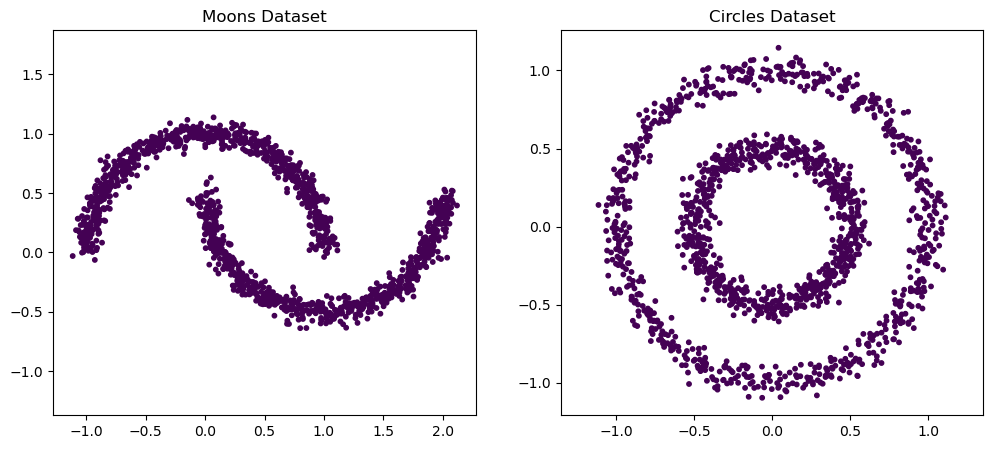

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from scipy import sparse
from scipy.sparse.linalg import eigsh

n_samples = 1500
random_state = 42


X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=random_state)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis')
    plt.title(title)
    plt.axis('equal')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plot_clusters(X_moons, np.zeros(n_samples), "Moons Dataset")
plt.subplot(1, 2, 2); plot_clusters(X_circles, np.zeros(n_samples), "Circles Dataset")
plt.show()

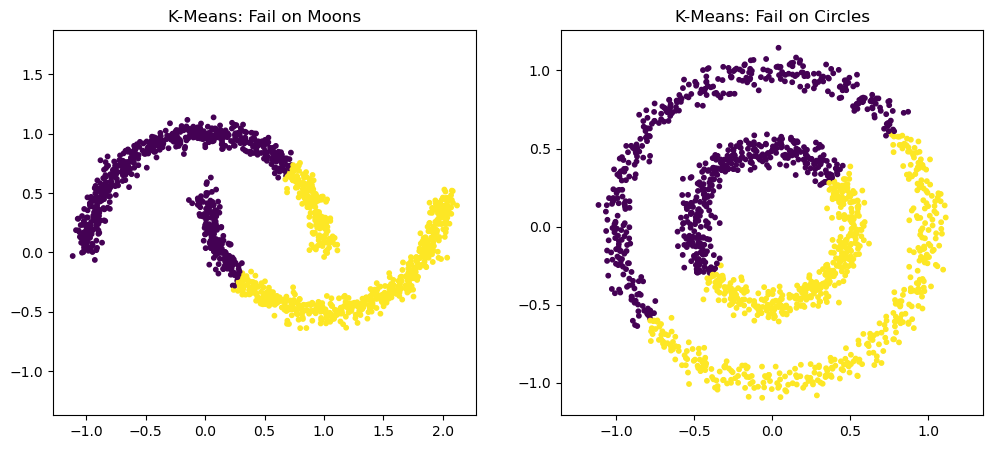

In [2]:
kmeans_moons = KMeans(n_clusters=2, random_state=random_state).fit(X_moons)
kmeans_circles = KMeans(n_clusters=2, random_state=random_state).fit(X_circles)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, kmeans_moons.labels_, "K-Means: Fail on Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, kmeans_circles.labels_, "K-Means: Fail on Circles")
plt.show()

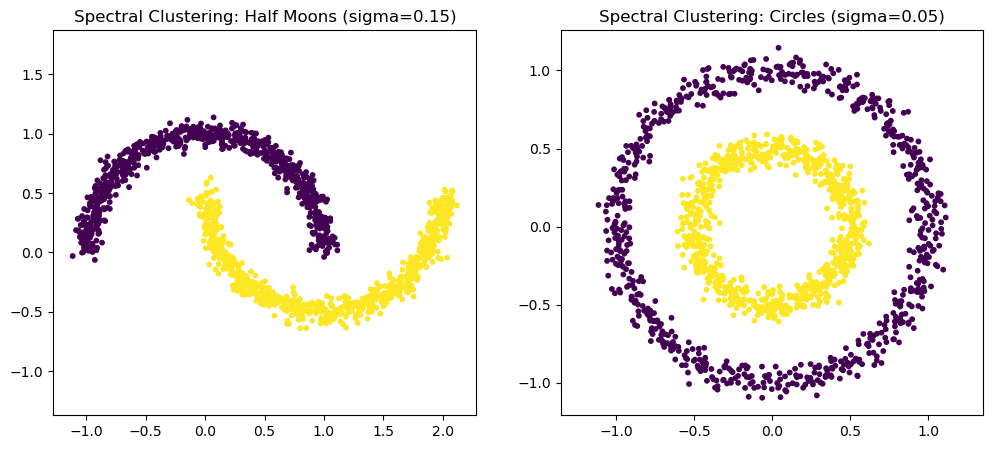

In [3]:
def spectral_clustering_dense(X, n_clusters, sigma=0.5):
    N = X.shape[0]
    
    dists = pairwise_distances(X, metric='euclidean')
    W = np.exp(- (dists ** 2) / (2 * sigma ** 2))
    np.fill_diagonal(W, 0) # Rimuoviamo self-loops
    
    d = np.sum(W, axis=1)
    d_inv_sqrt = np.power(d, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    
    I = np.eye(N)
    L_sym = I - D_inv_sqrt @ W @ D_inv_sqrt

    eigenvals, eigenvecs = np.linalg.eigh(L_sym)
    U = eigenvecs[:, :n_clusters]
    
    rows_norm = np.linalg.norm(U, axis=1, keepdims=True)
    rows_norm[rows_norm == 0] = 1 
    U_normalized = U / rows_norm
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(U_normalized)
    
    return labels


labels_sc_moons = spectral_clustering_dense(X_moons, n_clusters=2, sigma=0.15)
labels_sc_circles = spectral_clustering_dense(X_circles, n_clusters=2, sigma=0.05)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_clusters(X_moons, labels_sc_moons, "Spectral Clustering: Half Moons (sigma=0.15)")

plt.subplot(1, 2, 2)
plot_clusters(X_circles, labels_sc_circles, "Spectral Clustering: Circles (sigma=0.05)")

plt.show()